In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from pathlib import Path
import re


from visu_utils import TASK_LIST_CLASSIFICATION, make_results_tables_per_group_size, load_clustering_merged_mteb

from autorank import autorank, plot_stats, create_report, latex_table

EXPORT_PATH_TABLE = Path("../../papers/Distillation-MI-ICLR/tables/nlp/")
EXPORT_PATH_FIG = Path("../../papers/Distillation-MI-ICLR/figures/nlp/")

# Make sure the folders exist
EXPORT_PATH_TABLE.mkdir(parents=True, exist_ok=True)
EXPORT_PATH_FIG.mkdir(parents=True, exist_ok=True)

%reload_ext autoreload
%autoreload 2


In [2]:

# load mteb classification

MTEB_BASELINES_PATH = Path("../non_sync/baselines_mteb/mteb_detailed/en_Clustering.csv")

RESULTS_PATHS = [Path("../non_sync/mteb_benchmarking/results/experiments_gist_nll"),
                 Path("../non_sync/mteb_benchmarking/results/experiments_gist_mse")
                 ]



df_merged = load_clustering_merged_mteb(MTEB_BASELINES_PATH, RESULTS_PATHS)

df_merged = df_merged[
    (df_merged['Model Size (Million Parameters)'] >= 10) & (df_merged['Model Size (Million Parameters)'] <= 450)]

# select only last training step for each model
df_merged = df_merged.reset_index()

indices = df_merged.sort_values('Training step').groupby('Model')['Training step'].idxmax()
df_merged = df_merged.loc[indices]
df_merged = df_merged.drop('Training step', axis=1)
df_merged



,index,Model,Model Size (Million Parameters),loss,Dataset,ArxivClusteringP2P,ArxivClusteringS2S,RedditClustering,RedditClusteringP2P,StackExchangeClustering,StackExchangeClusteringP2P,TwentyNewsgroupsClustering
21,38,Alibaba-NLP/gte-base-en-v1.5,137.0,MTEB,MTEB,47.51,42.05,58.61,66.87,68.93,37.60,48.75
18,34,Alibaba-NLP/gte-large-en-v1.5,434.0,MTEB,MTEB,48.47,43.39,59.76,68.03,71.27,39.18,50.91
38,63,Alibaba-NLP/gte-multilingual-base,305.0,MTEB,MTEB,46.02,41.07,55.72,62.25,63.42,31.71,50.35
31,50,BAAI/bge-base-en-v1.5,109.0,MTEB,MTEB,48.75,42.81,56.61,62.66,66.11,35.24,50.75
29,48,BAAI/bge-large-en-v1.5,335.0,MTEB,MTEB,48.57,43.19,57.24,64.66,66.40,34.96,51.27
...,...,...,...,...,...,...,...,...,...,...,...,...
36,58,thenlper/gte-small,33.0,MTEB,MTEB,47.90,40.26,55.62,61.39,62.63,36.33,49.95
113,155,thtang/ALL_862873,118.0,MTEB,MTEB,14.79,12.25,18.38,27.10,23.66,27.34,20.17
26,43,w601sxs/b1ade-embed,335.0,MTEB,MTEB,48.66,42.81,59.77,63.79,66.31,34.99,52.98
48,75,w601sxs/b1ade-embed-kd,335.0,MTEB,MTEB,45.80,37.64,54.76,56.28,63.95,32.22,47.07


In [3]:
# melt columns back into rows with Accuracy
df_melted = df_merged.melt(id_vars=['Model', 'Model Size (Million Parameters)', 'loss', 'Dataset'],
                           value_vars=df_merged.columns[4:], var_name='Task', value_name='Score')

In [4]:
df_melted.head()

,Model,Model Size (Million Parameters),loss,Dataset,Task,Score
0,Alibaba-NLP/gte-base-en-v1.5,137.0,MTEB,MTEB,ArxivClusteringP2P,47.51
1,Alibaba-NLP/gte-large-en-v1.5,434.0,MTEB,MTEB,ArxivClusteringP2P,48.47
2,Alibaba-NLP/gte-multilingual-base,305.0,MTEB,MTEB,ArxivClusteringP2P,46.02
3,BAAI/bge-base-en-v1.5,109.0,MTEB,MTEB,ArxivClusteringP2P,48.75
4,BAAI/bge-large-en-v1.5,335.0,MTEB,MTEB,ArxivClusteringP2P,48.57


,Model,Models,Model Size (Million Parameters),Score
3,BAAI/bge-base-en-v1.5,MTEB,109.0,51.847143
5,BAAI/bge-small-en-v1.5,MTEB,33.0,49.278571
6,Hum-Works/lodestone-base-4096-v1,MTEB,69.0,45.451429
9,Lajavaness/bilingual-embedding-small,MTEB,118.0,43.682857
10,MSE/GIST/Student-m,MSE,109.0,48.557007
...,...,...,...,...
91,shibing624/text2vec-base-multilingual,MTEB,118.0,32.707143
92,technicolor/Angle_BERT,MTEB,109.0,37.071429
93,thenlper/gte-base,MTEB,109.0,52.640000
95,thenlper/gte-small,MTEB,33.0,50.582857


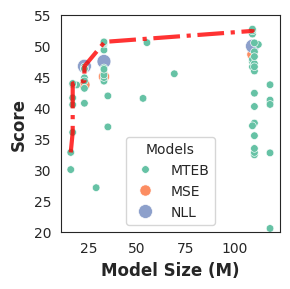

In [5]:

sns.set_style("white")

fig, ax = plt.subplots(1, 1, figsize=(3, 3))

df_avg = df_melted.groupby(['Model', 'loss']).mean(numeric_only=True)
df_avg = df_avg.reset_index()

# rename loss
df_avg['loss'] = df_avg['loss'].replace({"N/A": "MTEB"})
# rename column loss
df_avg = df_avg.rename(columns={"loss": "Models"})

# keep only less than 50M 
df_avg = df_avg[df_avg['Model Size (Million Parameters)'] <= 120]
df_avg = df_avg.dropna()

display(df_avg)

sns.scatterplot(data=df_avg, x='Model Size (Million Parameters)', y='Score', hue='Models', size="Models",
                sizes=(100, 30), ax=ax, palette="Set2")


def trace_pareto_frontier(df, x, y, ax):
    df = df.sort_values(x)
    pareto_front = [df.iloc[0]]
    for i in range(1, len(df)):
        if df.iloc[i][y] >= pareto_front[-1][y]:
            pareto_front.append(df.iloc[i])
    pareto_front = pd.DataFrame(pareto_front)
    ax.plot(pareto_front[x], pareto_front[y], 'red', linestyle="-.", lw=3, alpha=0.8)


trace_pareto_frontier(df_avg, 'Model Size (Million Parameters)', 'Score', ax)

# Change label sizes
ax.set_xlabel("Model Size (M)", fontsize=12, fontweight='bold')
ax.set_ylabel("Score", fontsize=12, fontweight='bold')


# set ylim
ax.set_ylim(20, 55)

# export
fig.tight_layout()
fig.savefig(EXPORT_PATH_FIG / "pareto_frontier_clustering_nlp_less_110.png")

